In [36]:
from pprint import pprint
import json

## Downloading Files from Bucket

In [6]:
import fsspec

mapper = fsspec.get_mapper('gcs://data-projectx/')

list(mapper)

['gis/.DS_Store',
 'gis/areas_pobladas/Areas_Pobladas.CPG',
 'gis/areas_pobladas/Areas_Pobladas.dbf',
 'gis/areas_pobladas/Areas_Pobladas.prj',
 'gis/areas_pobladas/Areas_Pobladas.sbn',
 'gis/areas_pobladas/Areas_Pobladas.sbx',
 'gis/areas_pobladas/Areas_Pobladas.shp.xml',
 'gis/areas_pobladas/Areas_Pobladas.shx',
 'gis/lagos_cuerpos_agua/Lagos_DGA.dbf',
 'gis/lagos_cuerpos_agua/Lagos_DGA.prj',
 'gis/lagos_cuerpos_agua/Lagos_DGA.sbn',
 'gis/lagos_cuerpos_agua/Lagos_DGA.sbx',
 'gis/lagos_cuerpos_agua/Lagos_DGA.shp.xml',
 'gis/lagos_cuerpos_agua/Lagos_DGA.shx',
 'gis/limites/.DS_Store',
 'gis/limites/comunales/division_comunal.dbf',
 'gis/limites/comunales/division_comunal.prj',
 'gis/limites/comunales/division_comunal.sbn',
 'gis/limites/comunales/division_comunal.sbx',
 'gis/limites/comunales/division_comunal.shp',
 'gis/limites/comunales/division_comunal.shp.xml',
 'gis/limites/comunales/division_comunal.shx',
 'gis/limites/provinciales/division_provincial.dbf',
 'gis/limites/provinci

In [20]:
import pandas as pd
import geopandas as gpd
from io import StringIO, BytesIO

def read_bytes_string(byte_file, encoding='utf-8'):
    s = str(byte_file,'utf-8')
    return StringIO(s) 

ls_df = pd.read_csv(read_bytes_string(mapper['nasa/procesados/data_final.csv']))
ls_df.head(5)

,id,nearest_pl,landslide_,trigger,fatalities,injuries,location_a,landslide1,cat_src,cat_id,countrynam,near,distance,population,continentc,tstamp,changeset_,latitude,longitude,geometry
0,3177,Grove Street from Anderson Avenue to Hine Hill...,Mudslide,Downpour,0.0,0.0,Known_within_1_km,Medium,glc,3177.0,United States,New Milford,2.12825,6523.0,NaN,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1.000000e+00,41.5585,-73.4020,POINT (-73.402 41.5585)
1,490,"Borneo, Muara",Landslide,Rain,0.0,0.0,Unknown,Medium,glc,490.0,Indonesia,Longnawang,215.44888,0.0,AS,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1.000000e+00,0.1115,113.9171,POINT (113.917 0.1115)
2,6760,"Ocean Falls, B.C.",Mudslide,Rain,0.0,0.0,Known_within_1km,Medium,glc,6760.0,Canada,Kitimat,199.44893,8987.0,NaN,Tue Feb 17 2015 15:42:41 GMT+0000 (UTC),3.910847e+09,52.3545,-127.6980,POINT (-127.698 52.3545)
3,2494,"road to Holberg, 3 km from hwy 19, Vancouver I...",Complex,Downpour,0.0,0.0,Known_within_1_km,Medium,glc,2494.0,Canada,Campbell River,178.23706,33430.0,NaN,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1.000000e+00,50.7053,-127.5062,POINT (-127.506 50.7053)
4,6415,Rennell Sound Road,Mudslide,Downpour,0.0,0.0,Known_within_15km,Small,glc,6415.0,Canada,Prince Rupert,176.02202,14708.0,NaN,Thu Dec 04 2014 15:14:07 GMT+0000 (UTC),1.280292e+09,53.3319,-132.4149,POINT (-132.415 53.3319)


In [22]:
ls_df.columns

Index(['id', 'nearest_pl', 'landslide_', 'trigger', 'fatalities', 'injuries',
       'location_a', 'landslide1', 'cat_src', 'cat_id', 'countrynam', 'near',
       'distance', 'population', 'continentc', 'tstamp', 'changeset_',
       'latitude', 'longitude', 'geometry'],
      dtype='object')

## Creating Polygons

In [133]:

def create_Point(lat, lon, properties_dict, add_bbox=False):
    aoi_point = \
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [lon, lat]
      }
    }
    
    aoi_point['properties'] = properties_dict
    
    if add_bbox:
        bbox = create_bbox(lat, lon)
        aoi_point['bbox'] = bbox
        
    return aoi_point

def create_Collection(feature_list):
    
    aoi_point_collection = {
        "type": "FeatureCollection",
        "features": []
    }
    
    for feature in feature_list:
        aoi_point_collection["features"].append(feature)
    return aoi_point_collection

def create_landslides_nasa_points(df):

    from dateutil.parser import parse

    point_list = []

    for idx, row in df.iterrows():
        properties_dict = {}

        # properties
        properties_dict['location']  = row['nearest_pl']
        properties_dict['severity']  = row['landslide1']
        properties_dict['date']      = parse(row['tstamp']).strftime('%Y-%m-%d')
        properties_dict['kind' ]     = row['landslide_']
        properties_dict['trigger']   = row['trigger']
        properties_dict['fatalities']= row['fatalities']
        properties_dict['injuries']  = row['injuries']

        point_list.append(create_Point(lon=row['longitude'], lat=row['latitude'], properties_dict=properties_dict))
        
    return point_list

def create_Polygon_around_Point(point):
    new_polygon = point
    new_polygon['geometry']['type'] = 'Polygon'
    lon, lat = new_polygon['geometry']['coordinates']
    
    new_coords = [
            [lon - 0.1, lat - 0.1], 
            [lon + 0.1, lat], 
            [lon + 0.1, lat + 0.1],
            [lon, lat + 0.1], 
            [lon - 0.1, lat - 0.1]
      ]
    new_polygon['geometry']['coordinates'] = new_coords
    
    return new_polygon

In [216]:
point_list = create_landslides_nasa_points(ls_df)

polygon_list = map(create_Polygon_around_Point, point_list)

feature_collection = create_Collection(polygon_list)

In [183]:
feature_collection['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[-73.502, 41.4585],
   [-73.302, 41.5585],
   [-73.302, 41.658500000000004],
   [-73.402, 41.658500000000004],
   [-73.502, 41.4585]]},
 'properties': {'location': 'Grove Street from Anderson Avenue to Hine Hill Road, New Milford, CT',
  'severity': 'Medium',
  'date': '2014-04-01',
  'kind': 'Mudslide',
  'trigger': 'Downpour',
  'fatalities': 0.0,
  'injuries': 0.0}}

## Intersecting with images

https://docs.descarteslabs.com/guides/catalog_v2.html

https://docs.descarteslabs.com/guides/scenes.html

In [52]:
import descarteslabs as dl
from shapely.geometry import Polygon

In [221]:
def search_scenes(aoi, product_ids, start_date, end_date, limit=10):
    scenes, ctx = dl.scenes.search(
        aoi,
        products=product_ids,
        start_datetime=start_date,
        end_datetime=end_date,
        limit=limit
    )
    
    return scenes

In [240]:
def date_interval(date, delta=1, return_str=False):
    from dateutil.relativedelta import relativedelta
    from dateutil.parser import parse
    
    if return_str:
        return (parse(date) - relativedelta(days=delta)).strftime('%Y-%m-%d'), (parse(date) + relativedelta(days=delta)).strftime('%Y-%m-%d')
    
    return parse(date) - relativedelta(days=delta), parse(date) + relativedelta(days=delta)

In [250]:
date_interval(point_list[0]['properties']['date'], 2)

(datetime.datetime(2014, 3, 30, 0, 0), datetime.datetime(2014, 4, 3, 0, 0))

In [ ]:
date_interval()

In [254]:
scenes = search_scenes(aoi=Polygon(features[0]['geometry']['coordinates']), 
                       product_ids=["landsat:LC08:PRE:TOAR"], 
                       start_date=date_interval(point_list[0]['properties']['date'], 2)[0], 
                       end_date=date_interval(point_list[0]['properties']['date'], 2)[1])

In [255]:
scenes

SceneCollection of 1 scene
  * Dates: Apr 01, 2014 to Apr 01, 2014
  * Products: landsat:LC08:PRE:TOAR: 1

In [257]:
arr

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, 933, 1051, ..., --, --, --],
         [--, 876, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, 871, 909, ..., --, --, --],
         [--, 843, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, 968, 1054, ..., --, --, --],
         [--, 940, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True, Fa

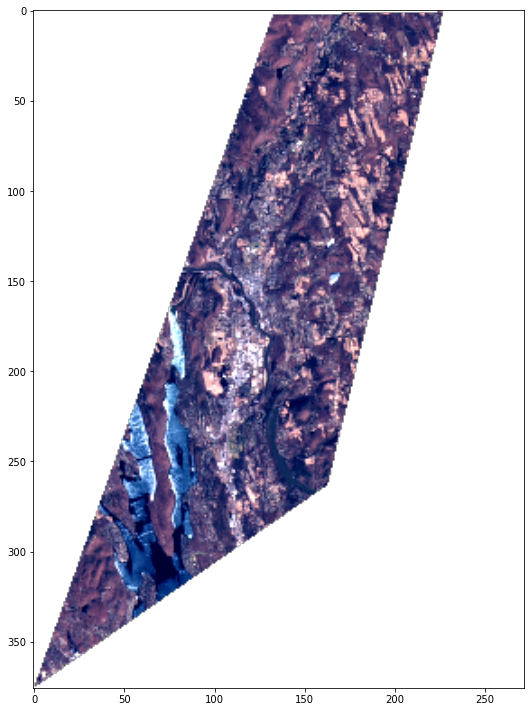

In [256]:
scene = scenes[-1]
ctx_lowres = ctx.assign(resolution=60)
arr = scene.ndarray("red green blue", ctx_lowres)
dl.scenes.display(arr)

## MISC

In [ ]:
a = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [102.0, 0.5]
      },
      "properties": {
        "prop0": "value0"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [102.0, 0.0], [103.0, 1.0], [104.0, 0.0], [105.0, 1.0]
        ]
      },
      "properties": {
        "prop0": "value0",
        "prop1": 0.0
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [100.0, 0.0], [101.0, 0.0], [101.0, 1.0],
            [100.0, 1.0], [100.0, 0.0]
          ]
        ]
      },
      "properties": {
        "prop0": "value0",
        "prop1": { "this": "that" }
      }
    }
  ]
}